In [1]:
from gcm import GCM
import pandas as pd
from scipy.stats import normaltest

from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

## Step 0: Functions

In [2]:
def scatter(df, columns):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax.scatter(df[columns[0]], df[columns[1]], alpha=0.5)
    ax.set_xlabel(columns[0])
    ax.set_ylabel(columns[1])
    ax.set_title(f"Scatter plot of {columns[0]} vs {columns[1]}")
    plt.show()

In [3]:
def compute_multipole(df: pd.DataFrame, columns: list, method="pearson"):
    corr_matrix = df[columns].corr(method=method)
    eigenvalues = np.linalg.eigvalsh(corr_matrix)
    multipole = 1 - min(eigenvalues)
    return multipole

In [4]:
def keep_normal_columns(df, alpha=0.05):
    normal_cols = []
    for col in df.columns:
        # Run normality test on the column
        stat, p = normaltest(df[col].values)
        if p > alpha:
            normal_cols.append(col)
    return df[normal_cols]


In [5]:
def plot_distributions(df, cols, ncols=3):
    nrows = (len(cols) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.histplot(df[col], kde=True, ax=axes[i], bins=40, color="steelblue")
        axes[i].set_title(col)
    plt.tight_layout()
    plt.show()

In [6]:
def prep_lcd(df):
    numeric_df = df.dropna(axis=1).iloc[:,2:]  # Drop duplicate column.
    
    columns_to_drop = ['policy_code', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths','delinq_amnt', 'tax_liens','pub_rec_bankruptcies']
    numeric_df = numeric_df.drop(columns=columns_to_drop)
    rename_map = {
        # Scenario 1
        'mort_acc': 'number_of_mortgage_accounts', # Number of mortgage accounts.
        'tot_hi_cred_lim': 'total_credit_limit', # Total high credit/credit limit
        'total_bal_ex_mort': 'balance_excl_mortgage', # Total credit balance excluding mortgage
    
        # Scenario 2
        'delinq_2yrs': 'delinquencies_2yrs', # The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
        'int_rate': 'interest_rate', # Interest Rate on the loan
        # total_credit_lim
        
        # Scenario 3
        'annual_inc': 'annual_income' # The self-reported annual income provided by the borrower during registration.
        # interest_rate
        # total_credit_limit
    }
    
    
    numeric_df = numeric_df.rename(columns=rename_map)
    return numeric_df

In [7]:
def prep_heart(df):
    return df
    

In [8]:
def prep_body(df):
    return df

In [9]:
def prep_dataset(dataset):    
    df = pd.read_csv(f"./data/{dataset['path']}",nrows=10000)
    numeric_df = df.select_dtypes(include="number")
    if ds['name'] == 'Loan Club':
        numeric_df = prep_lcd(numeric_df)
    elif ds['name'] == 'Heart Sensor':
        numeric_df = prep_heart(numeric_df)
    
    df_train_prep = numeric_df.iloc[:int(0.9*len(numeric_df))]
    df_test_prep = numeric_df.iloc[int(0.9*len(numeric_df)):]
    print("Original number of columns:", numeric_df.shape[1])
    print("Number of columns after filter:", df_train_prep.shape[1])
    return df_train_prep, df_test_prep

In [10]:
def read_json(dataset):
    import json
    with open(f"./data/dataset_json/{dataset}.json", 'r') as f:
        data = json.load(f)
    return data


# Step 1: Load Data

In [22]:
name = 'HeartSensors'
ds = read_json(name)
print(ds['description'])
# name = 'Heart Sensor'
# name = 'Body Measurements'

df_train, df_test = prep_dataset(ds)
df_train.head()


Original number of columns: 14
Number of columns after filter: 14


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


# Step 2: Check Correlations

In [23]:
scenarios = ds['mvc']
scenarios_dict = {i: {'columns': s, 'Original Multipole': None,
                      'Synthetic Multipole': None}
                  for i, s in enumerate(scenarios)}

# pairwise correlations:

for i, s in enumerate(scenarios):
    corr_matrix = df_train[s].corr(method='pearson')
    print(f"Scenario {i + 1}")
    print("Pairwise correlation matrix")
    display(corr_matrix)
    multipole_val = compute_multipole(df_train, s, method='pearson')
    
    scenarios_dict[i]['Original Multipole'] = multipole_val
    print(f"Columns: {s}, Multipole: {multipole_val:.4f}")
    
    
    print("\n")

Scenario 1
Pairwise correlation matrix


,age,chol,trestbps
age,1.000000,0.231159,0.273670
chol,0.231159,1.000000,0.120434
trestbps,0.273670,0.120434,1.000000


Columns: ['age', 'chol', 'trestbps'], Multipole: 0.3047


Scenario 2
Pairwise correlation matrix


,thalach,age,exang
thalach,1.000000,-0.396750,-0.375433
age,-0.396750,1.000000,0.085334
exang,-0.375433,0.085334,1.000000


Columns: ['thalach', 'age', 'exang'], Multipole: 0.5053


Scenario 3
Pairwise correlation matrix


,oldpeak,slope,exang
oldpeak,1.000000,-0.581783,0.309033
slope,-0.581783,1.000000,-0.264234
exang,0.309033,-0.264234,1.000000


Columns: ['oldpeak', 'slope', 'exang'], Multipole: 0.5840


Scenario 4
Pairwise correlation matrix


,ca,thal,target
ca,1.000000,0.149994,-0.396775
thal,0.149994,1.000000,-0.340542
target,-0.396775,-0.340542,1.000000


Columns: ['ca', 'thal', 'target'], Multipole: 0.4547


# Step 3: Fit GCM and Generate Synthetic Data

In [24]:
# 1. Initialize the GCM model and fit it to your source data
gcm = GCM()
gcm.fit(df_train)

# # 2. Generate synthetic samples
synthetic_data = pd.DataFrame(gcm.sample(num_samples=1000000), columns=df_train.columns)

# 3. Verify that the correlation structure is preserved
corr_real = np.corrcoef(df_train, rowvar=False)
corr_synth = np.corrcoef(synthetic_data, rowvar=False)

synthetic_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,46.038554,0.916525,0.619574,150.235969,271.915118,0.210864,1.166682,163.839199,0.244411,1.719901,1.224378,1.150412,2.427383,0.766453
1,62.456293,1.103744,-0.184985,127.128265,173.647271,0.239380,-0.035461,121.221905,1.128106,-0.624698,1.253277,1.157429,2.183475,0.921503
2,54.678055,-0.348697,1.119879,144.762996,203.474787,0.290801,1.065080,139.187460,-0.016216,1.477206,1.432264,1.830457,1.115976,1.075660
3,54.326294,0.898071,1.846914,132.029770,237.525838,-0.117149,-0.097267,175.481553,-0.139930,0.929353,1.875632,-0.380635,0.622696,1.006581
4,45.880162,0.469444,2.980693,120.195277,137.886736,0.207330,1.269375,157.512791,-0.251576,0.254323,1.343722,0.593492,1.915705,0.949454


# Step 4: Validate Results

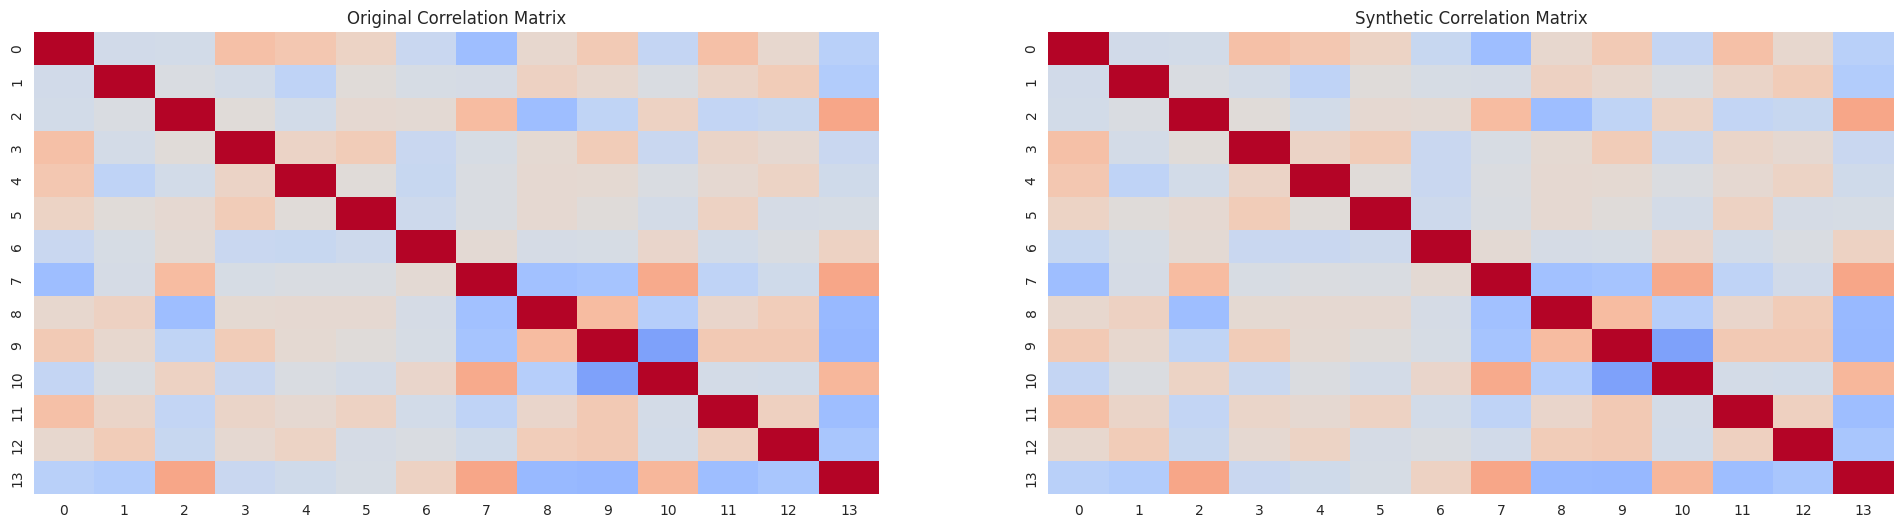

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(24,6))

sns.heatmap(corr_real, ax=axes[0], cmap="coolwarm", center=0, cbar=False)
axes[0].set_title("Original Correlation Matrix")
sns.heatmap(corr_synth, ax=axes[1], cmap="coolwarm", center=0, cbar=False)
axes[1].set_title("Synthetic Correlation Matrix")
plt.show()


In [26]:
# Are the multipoles preserved?
for i, s in enumerate(scenarios):
    scenarios_dict[i]['Synthetic Multipole'] = compute_multipole(pd.DataFrame(synthetic_data, columns=df_train.columns), s, method="pearson")
    
    
# Convert to DataFrame
results = pd.DataFrame.from_dict(scenarios_dict, orient='index')

# Format numeric columns nicely
numeric_cols = ['Original Multipole', 'Synthetic Multipole']
results[numeric_cols] = results[numeric_cols].applymap(lambda x: f"{x:.4f}" if x is not None else "-")
display(results)


,columns,Original Multipole,Synthetic Multipole
0,"[age, chol, trestbps]",0.3047,0.3036
1,"[thalach, age, exang]",0.5053,0.5046
2,"[oldpeak, slope, exang]",0.5840,0.5839
3,"[ca, thal, target]",0.4547,0.4552


### Correlations are preserved well in the synthetic data.

# Step 5: Downstream task analysis

In [34]:
# Features and target
features = ds['reg']['features']
target = ds['reg']['target']

X_train = df_train[features]
y_train = df_train[target]

X_synth = synthetic_data[features]
y_synth = synthetic_data[target]

X_test = df_test[features]
y_test = df_test[target]

# Train models
reg_org = LinearRegression().fit(X_train, y_train)
reg_synth = LinearRegression().fit(X_synth, y_synth)


# Evaluate on the same held-out test set
y_pred_org = reg_org.predict(X_test)
y_pred_synth = reg_synth.predict(X_test)


metrics = {
    "R2_org": r2_score(y_test, y_pred_org),
    "MSE_org": mean_squared_error(y_test, y_pred_org),
    "R2_synth": r2_score(y_test, y_pred_synth),
    "MSE_synth": mean_squared_error(y_test, y_pred_synth)
}

print(metrics)

{'R2_org': 0.37518213427580704, 'MSE_org': 0.15501184113357291, 'R2_synth': 0.37452938864353313, 'MSE_synth': 0.15517378160903197}


In [28]:
# Features and target
features = ds['reg']['features']
target = ds['reg']['target']

X_train_synth = pd.concat([df_train[features], synthetic_data[features]], ignore_index=True)
y_train_synth = pd.concat([df_train[target], synthetic_data[target]], ignore_index=True)

X_test = df_test[features]
y_test = df_test[target]

# Train models
reg_org_synth = LinearRegression().fit(X_train_synth, y_train_synth)


# Evaluate on the same held-out test set
y_pred_org_synth = reg_org_synth.predict(X_test)


metrics = {
    "R2_org_synth": r2_score(y_test, y_pred_org_synth),
    "MSE_org_synth": mean_squared_error(y_test, y_pred_org_synth),
}

print(metrics)

{'R2_org_synth': 0.3745299941251645, 'MSE_org_synth': 0.15517363139434123}


# The R2 and MSE values for the models trained on original and synthetic data are similar, indicating that the synthetic data is effective for training predictive linear models.